# lr-stacking 데모
* lr: 독립변수의 선형 결합을 이용해 사건의 발생 가능성을 예측하는데 사용되는 통계 기법(Classification)
* 알고리즘 rf, lgbm, lr 적용한 앙상블 기법  stacking 적용
* 개별 모델이 예측한 데이터를 다시 training set 으로 사용해서 학습  

## 라이브러리 import 및 설정

In [40]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


rcParams['figure.figsize'] = (16, 8)       #그림 사이즈 지정
plt.style.use('fivethirtyeight')           #그림 기본 스타일
pd.set_option('max_columns', 100)          #칼럼 100개 허용
pd.set_option("display.precision", 4)      #소수점 4자리허용
warnings.simplefilter('ignore')            #경고분 무시

## 학습데이터 로드

In [41]:
feature_file = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\feature.csv'
sample_file  = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\sample_submission.csv'
tst_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\testset.csv'
trn_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\trainset.csv'    
val_dir      = Path('C:\\Users\\USER\\Desktop\\Dataset\\val')
tst_dir      = Path('C:\\Users\\USER\\Desktop\\Dataset\\tst')

## Stacking Feature 생성

In [42]:
model_names = ['lrcvPolyfeature','rfcvFeature','lgbmcvFeature']

In [43]:
trn = []
tst = []
for model in model_names:
    trn.append(pd.read_csv(val_dir / f'{model}.val.csv', delimiter=',',header=None))
    tst.append(pd.read_csv(tst_dir / f'{model}.tst.csv', delimiter=',',header=None))
    
trn = np.hstack(trn)
tst = np.hstack(tst)
print(trn.shape, tst.shape)

(4280, 18) (1833, 18)


In [44]:
feature_names = []
for model in model_names:
    feature_names += [f'{model}_0CO', f'{model}_1EL', f'{model}_2GR', f'{model}_3HI', f'{model}_4MI', f'{model}_5PH']
    
feature_names

['lrcvPolyfeature_0CO',
 'lrcvPolyfeature_1EL',
 'lrcvPolyfeature_2GR',
 'lrcvPolyfeature_3HI',
 'lrcvPolyfeature_4MI',
 'lrcvPolyfeature_5PH',
 'rfcvFeature_0CO',
 'rfcvFeature_1EL',
 'rfcvFeature_2GR',
 'rfcvFeature_3HI',
 'rfcvFeature_4MI',
 'rfcvFeature_5PH',
 'lgbmcvFeature_0CO',
 'lgbmcvFeature_1EL',
 'lgbmcvFeature_2GR',
 'lgbmcvFeature_3HI',
 'lgbmcvFeature_4MI',
 'lgbmcvFeature_5PH']

In [45]:
df = pd.read_csv(trn_file, header=None)
y = pd.DataFrame(df[0].values.flatten())
y

,0
0,HI
1,PH
2,GR
3,PH
4,EL
...,...
4275,EL
4276,PH
4277,EL
4278,PH


In [46]:
seed=150
kfold=10

## Stratified K-Fold Cross Validation
*Stratified N-Fold CV: N-Fold CV에서 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 나누는 방식.
현재 사용하는 데이터처럼 분류학습에서 종속변수의 범주의 분포가 균일하지 않을 때 사용된다.

In [47]:
cv = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=seed)

### [수치형 > 범주형 변환_종속변수]

In [48]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

label_str=y
label_int=le.fit_transform(label_str).astype('int')
y
label_int

array([3, 5, 2, ..., 1, 5, 1])

## Logistic Regression 모델 학습

In [49]:
p_val = np.zeros((trn.shape[0], 6))
p_tst = np.zeros((tst.shape[0], 6))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LogisticRegression( C= 1.0, 
                             penalty='l2', 
                             solver='liblinear',
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], label_int[i_trn])
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / kfold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5
training model for CV #6
training model for CV #7
training model for CV #8
training model for CV #9
training model for CV #10


** ( 범주값 출력: clf.pedict(), 확률값출력: clf.predict_proba() ) **

In [50]:
print(f'{accuracy_score(label_int, np.argmax(p_val, axis=1)) * 100:.4f}%')
#91.4252rf 91.4486lr 91.5187%lr

91.5888%


## Simple way Cross Validation

In [51]:
scores = cross_val_score(clf, trn,y, cv=5) # model, train, target, cross validation
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.4f}%'.format(scores.mean()*100))
#88.2% 88.6682% 91.5888%

cross-val-score 
[0.92873832 0.9182243  0.90771028 0.91238318 0.91588785]
cross-val-score.mean 
91.6589%


### [stacking 사용을 위해 p_val,p_tst 저장]

In [52]:
val_dir = Path('C:\\Users\\USER\\Desktop\\Dataset\\val')
tst_dir = Path('C:\\Users\\USER\\Desktop\\Dataset\\tst')
name = 'lrcvStacking1'
model_name = f'{name}'
p_val_file = val_dir / f'{name}.val.csv'
p_tst_file = tst_dir / f'{name}.tst.csv'

In [53]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화
여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

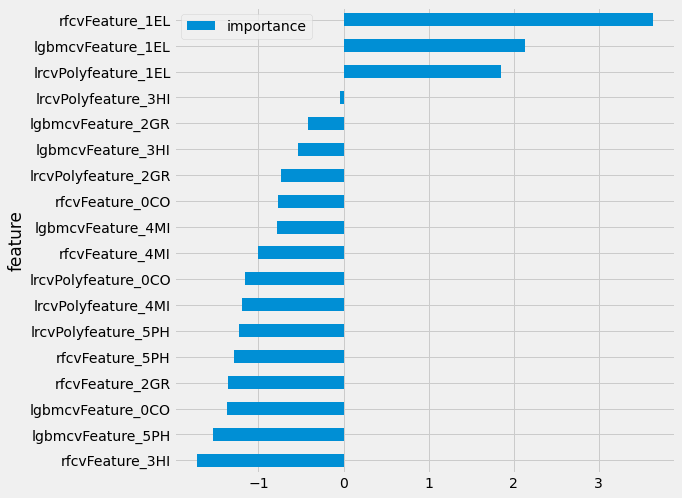

In [54]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.coef_[1, :].T})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh', figsize=(8, 8))

### [수치형 > 범주형 변환_종속변수]

In [55]:
pt=np.zeros(shape=(1833,))
pt = pt.astype(np.int64)
for x in range(0,1833):
    pt[x] = np.argmax(p_tst[x,:])
target=le.inverse_transform(pt)
target

array(['HI', 'EL', 'HI', ..., 'PH', 'PH', 'CO'], dtype=object)

## 제출 파일 생성

In [56]:
#sub = pd.read_csv(sample_file)
#sub['class']
sub = pd.read_csv(sample_file)
sub['class'] = target
sub.to_csv('C:\\Users\\USER\\Desktop\\Dataset\\sub\\lrstacking-sub.csv',index=False,header=False)